# Bottlers FC Analysis
Identifying the biggest "bottlers" in European football - teams that consistently underperform despite being close to success.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load match, team, and league data

In [2]:
try:
    matches = pd.read_csv("data/games.csv", parse_dates=['date'])
    teams = pd.read_csv("data/teams.csv")
    leagues = pd.read_csv("data/leagues.csv")
    print("Data files ")
except FileNotFoundError as e:
    print("Error: Missing data files. Please download from Kaggle and place in /data folder.")
    print("Dataset: https://www.kaggle.com/datasets/technika148/football-database")
    raise e

Data files 


### Assign points for wins, draws, and losses

In [3]:
matches['pointsHome'] = np.where(matches['homeGoals'] > matches['awayGoals'], 3,
                         np.where(matches['homeGoals'] == matches['awayGoals'], 1, 0))
matches['pointsAway'] = np.where(matches['awayGoals'] > matches['homeGoals'], 3,
                         np.where(matches['awayGoals'] == matches['homeGoals'], 1, 0))



### Aggregate total points per season, league, and team

In [4]:
final_points = pd.DataFrame({
    'teamID': pd.concat([matches['homeTeamID'], matches['awayTeamID']]),
    'season': pd.concat([matches['season'], matches['season']]),
    'leagueID': pd.concat([matches['leagueID'], matches['leagueID']]),
    'points': pd.concat([matches['pointsHome'], matches['pointsAway']])
}).groupby(['season', 'leagueID', 'teamID']).sum().reset_index()



### Rank teams to get final league positions

In [5]:
final_points['final_position'] = final_points.groupby(['season', 'leagueID'])['points'] \
                                             .rank(method='first', ascending=False).astype(int)



### Determine league size for normalization

In [6]:
league_sizes = final_points.groupby('leagueID')['final_position'].max().reset_index()
league_sizes = league_sizes.rename(columns={'final_position': 'league_size'})
final_points = final_points.merge(league_sizes, on='leagueID', how='left')



### Apply recency weighting (oldest=1, newest=3)

In [7]:
min_season = final_points['season'].min()
max_season = final_points['season'].max()
final_points['season_weight'] = 1 + 2 * (
    1 - ((final_points['season'] - min_season) / (max_season - min_season))
)


### Bottle Score Formula
The bottle score is calculated as:
- 0 for champions (1st place)
- `(0.5)^((position-2)/(league_size-2))` for others
- Multiplied by recency weight (recent seasons weighted more heavily)

Higher scores indicate more "bottling" behavior.

In [8]:
final_points['bottle_score'] = np.where(
    final_points['final_position'] == 1,
    0.0,
    (0.5) ** ((final_points['final_position'] - 2) / (final_points['league_size'] - 2))
)


In [9]:
final_points['bottle_score'] *= final_points['season_weight']

### Calculate average bottle score per team

In [10]:
bottle_avg = final_points.groupby(['teamID', 'leagueID'])['bottle_score'].mean().reset_index()

### Save results to CSV (IDs and scores only)

In [11]:
bottle_avg[['teamID', 'leagueID', 'bottle_score']].to_csv(
    "bottlers.csv", index=False
)


### Merge team and league names for readable output

In [12]:
bottle_display = bottle_avg.merge(leagues[['leagueID', 'name']], on='leagueID', how='left') \
                           .rename(columns={'name': 'leagueName'}) \
                           .merge(teams[['teamID', 'name']], on='teamID', how='left') \
                           .rename(columns={'name': 'teamName'})



In [13]:
print("\nBottling Performance Report:")

print(f"\nBasic Stats:")
print(f"- Average bottle score: {bottle_display['bottle_score'].mean():.2f}")
print(f"- Median bottle score: {bottle_display['bottle_score'].median():.2f}")
print(f"- Standard deviation: {bottle_display['bottle_score'].std():.2f} (higher = more inconsistent bottling)")

print(f"\nBottling Percentiles:")
print(f"- 25th percentile (mild bottlers): {bottle_display['bottle_score'].quantile(0.25):.2f}")
print(f"- 75th percentile (serious bottlers): {bottle_display['bottle_score'].quantile(0.75):.2f}")
print(f"- 90th percentile (professional bottlers): {bottle_display['bottle_score'].quantile(0.9):.2f}")

worst = bottle_display.loc[bottle_display['bottle_score'].idxmax()]
best = bottle_display.loc[bottle_display['bottle_score'].idxmin()]
median_idx = (bottle_display['bottle_score'] - bottle_display['bottle_score'].median()).abs().idxmin()
median_team = bottle_display.loc[median_idx]

print(f"\nBottling Hall of Fame:")
print(f"- WORST bottler: {worst['teamName']} ({worst['leagueName']}) with score {worst['bottle_score']:.2f}")
print(f"- BEST bottler (didnt bottle much): {best['teamName']} ({best['leagueName']}) with score {best['bottle_score']:.2f}")
print(f"- Most average bottler: {median_team['teamName']} ({median_team['leagueName']}) with score {median_team['bottle_score']:.2f}")

league_stats = bottle_display.groupby('leagueName')['bottle_score'].agg(['mean', 'max'])
league_stats.columns = ['Avg Bottle Score', 'Worst Score']
league_stats = league_stats.sort_values('Avg Bottle Score', ascending=False)

print(f"\nLeague Bottling Rankings:")
display(league_stats.style.background_gradient(cmap='Reds'))

high_bottle = bottle_display[bottle_display['bottle_score'] > bottle_display['bottle_score'].quantile(0.9)]
low_bottle = bottle_display[bottle_display['bottle_score'] < bottle_display['bottle_score'].quantile(0.1)]

print(f"The gap between best and worst: {worst['bottle_score'] - best['bottle_score']:.2f} points")


Bottling Performance Report:

Basic Stats:
- Average bottle score: 1.30
- Median bottle score: 1.36
- Standard deviation: 0.36 (higher = more inconsistent bottling)

Bottling Percentiles:
- 25th percentile (mild bottlers): 1.12
- 75th percentile (serious bottlers): 1.54
- 90th percentile (professional bottlers): 1.72

Bottling Hall of Fame:
- WORST bottler: Roma (Serie A) with score 1.90
- BEST bottler (didnt bottle much): Bayern Munich (Bundesliga) with score 0.00
- Most average bottler: Werder Bremen (Bundesliga) with score 1.37

League Bottling Rankings:


,Avg Bottle Score,Worst Score
leagueName,,
Ligue 1,1.326260,1.885518
La Liga,1.305144,1.799851
Bundesliga,1.292583,1.861524
Premier League,1.287934,1.858198
Serie A,1.275351,1.895025


The gap between best and worst: 1.90 points


### Display top bottlers per league

In [14]:
print("\nThe top bottlers in each league were,\n")

for league_name, df_league in bottle_display.groupby('leagueName'):
    print(f"\n{league_name}")
    display(
        df_league[['teamName', 'bottle_score']]
        .sort_values(by='bottle_score', ascending=False)
        .reset_index(drop=True)
        .head(3)
        .set_index(pd.Index(range(1, 4)))
    )
    print()



The top bottlers in each league were,


Bundesliga


,teamName,bottle_score
1,Borussia Dortmund,1.861524
2,Bayer Leverkusen,1.753268
3,Borussia M.Gladbach,1.710752




La Liga


,teamName,bottle_score
1,Atletico Madrid,1.799851
2,Sevilla,1.768013
3,Malaga,1.764401




Ligue 1


,teamName,bottle_score
1,Lyon,1.885518
2,SC Bastia,1.748144
3,Marseille,1.737578




Premier League


,teamName,bottle_score
1,Tottenham,1.858198
2,Manchester United,1.830976
3,Arsenal,1.811913




Serie A


,teamName,bottle_score
1,Roma,1.895025
2,Napoli,1.891704
3,Lazio,1.770966


In [15]:
league_colors = {
    'Premier League': '#432060',
    'La Liga': '#ff5049',
    'Bundesliga': '#d2000c',
    'Serie A': '#005cff',
    'Ligue 1': '#122c62'
}

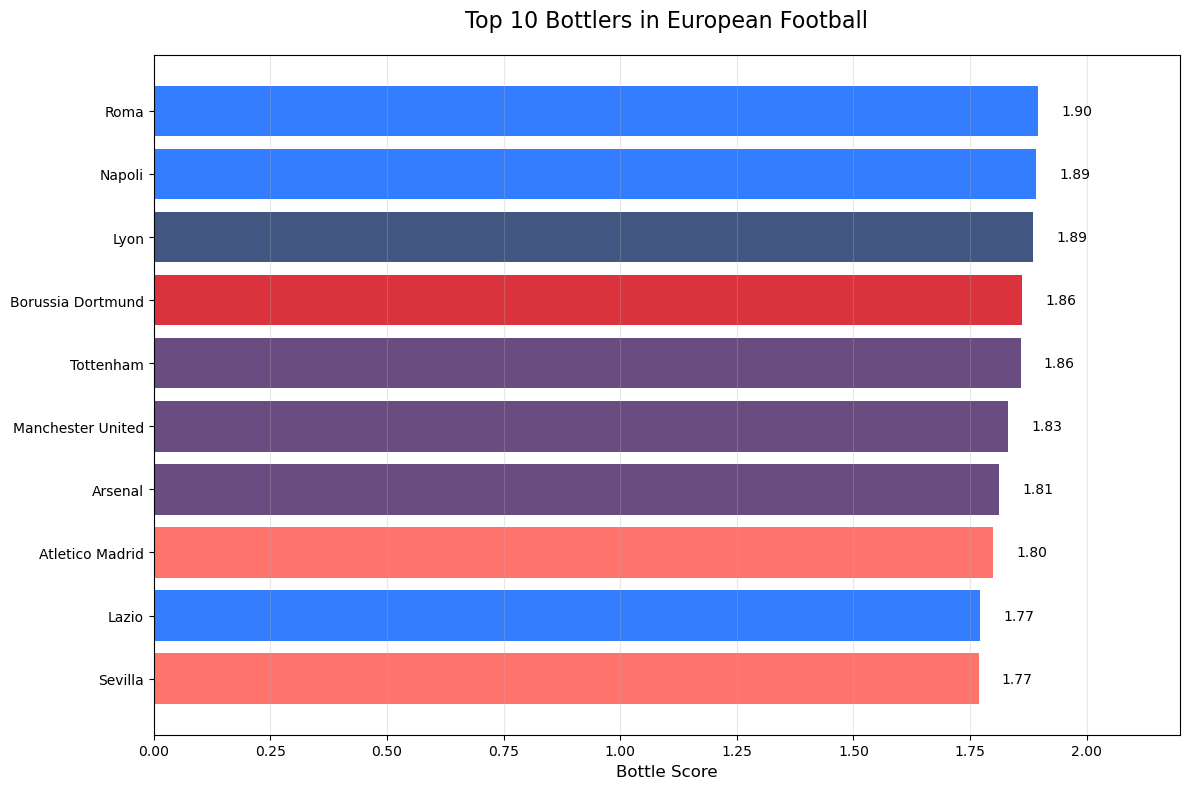

In [16]:
plt.figure(figsize=(12,8))
top10 = bottle_display.nlargest(10, 'bottle_score').sort_values('bottle_score', ascending=True)
bars = plt.barh(top10['teamName'],
                top10['bottle_score'],
                color=[league_colors[league] for league in top10['leagueName']],
                alpha=0.8)


plt.title('Top 10 Bottlers in European Football', fontsize=16, pad=20)
plt.xlabel('Bottle Score', fontsize=12)
plt.xlim(0, 2.2)
plt.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.05, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             ha='left', va='center')

plt.tight_layout()
plt.savefig('output/visualizations/top10_bottlers.png', dpi=120, bbox_inches='tight')
plt.show()

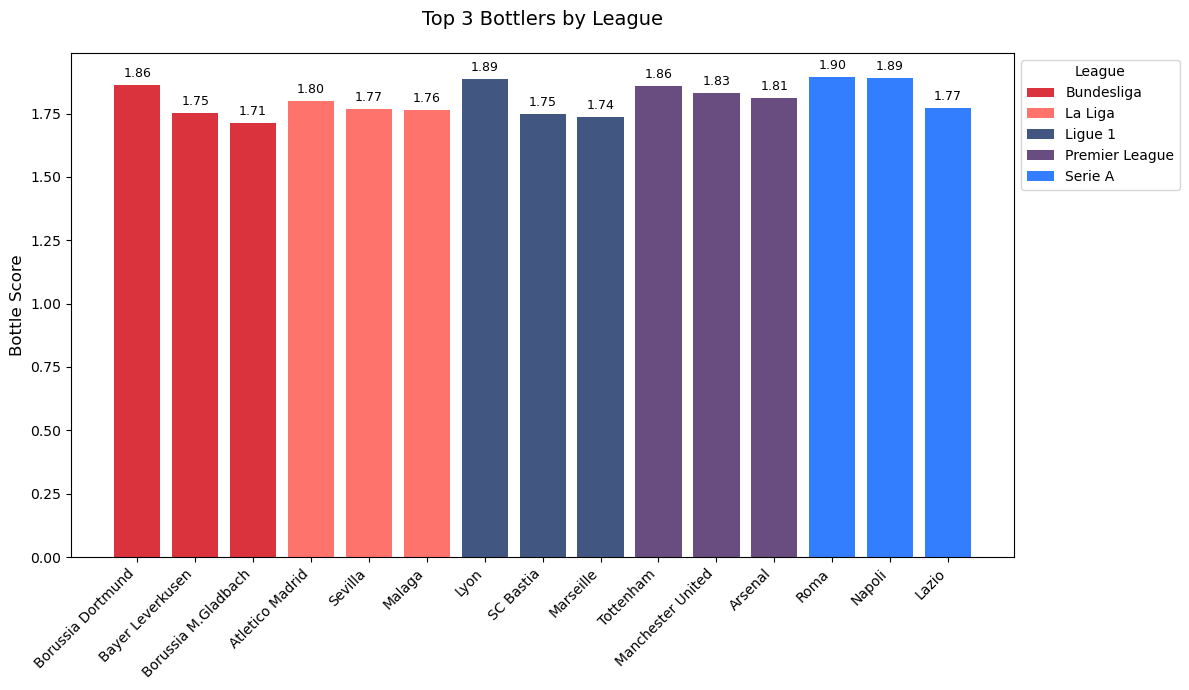

In [17]:
plt.figure(figsize=(12, 7))

for league, group in bottle_display.groupby('leagueName'):
    top3 = group.nlargest(3, 'bottle_score')
    plt.bar(top3['teamName'],
            top3['bottle_score'],
            alpha=0.8,
            label=league,
            color=league_colors[league])

plt.title('Top 3 Bottlers by League', fontsize=14, pad=20)
plt.ylabel('Bottle Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='League', bbox_to_anchor=(1, 1), loc='upper left')

for bar in plt.gca().patches:
    plt.gca().text(bar.get_x() + bar.get_width()/2,
                  bar.get_height() + 0.02,
                  f'{bar.get_height():.2f}',
                  ha='center',
                  va='bottom',
                  fontsize=9)

plt.tight_layout()
plt.savefig('output/visualizations/top3_bottlers_by_league.png', dpi=120, bbox_inches='tight')
plt.show()